# OT-CFM using MNIST
This notebook contains an implementation of OT-CFM using MNIST dataset.

Output:
- Series of images showing the progress along the probability path from gaussian noise to target MNIST distribution


## Dependencies

In [2]:
#install dependencies
!pip3 uninstall --yes torch torchaudio torchvision torchtext torchdata
!pip3 install torch torchaudio torchvision torchtext torchdata

Found existing installation: torch 2.0.1+cu118
Uninstalling torch-2.0.1+cu118:
  Successfully uninstalled torch-2.0.1+cu118
Found existing installation: torchaudio 2.0.2+cu118
Uninstalling torchaudio-2.0.2+cu118:
  Successfully uninstalled torchaudio-2.0.2+cu118
Found existing installation: torchvision 0.15.2+cu118
Uninstalling torchvision-0.15.2+cu118:
  Successfully uninstalled torchvision-0.15.2+cu118
Found existing installation: torchtext 0.15.2
Uninstalling torchtext-0.15.2:
  Successfully uninstalled torchtext-0.15.2
Found existing installation: torchdata 0.6.1
Uninstalling torchdata-0.6.1:
  Successfully uninstalled torchdata-0.6.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 104.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 119.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 96.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!pip install POT

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 790.0/790.0 kB 12.3 MB/s eta 0:00:00


In [5]:
!pip install torchsde
!pip install torchdyn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.4 MB/s eta 0:00:00


## Import packages

In [4]:
#clone the CFM repo and corresponding packages
! git clone https://github.com/atong01/conditional-flow-matching.git

Cloning into 'conditional-flow-matching'...
remote: Enumerating objects: 1337, done.
remote: Counting objects: 100% (219/219), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 1337 (delta 110), reused 159 (delta 96), pack-reused 1118
Receiving objects: 100% (1337/1337), 124.60 MiB | 26.53 MiB/s, done.
Resolving deltas: 100% (757/757), done.


In [6]:
#change to CFM directory
%cd /content/conditional-flow-matching

/content/conditional-flow-matching


In [7]:
#import packages
import sys
import os

# Get the current working directory
current_directory = os.getcwd()




In [8]:
%load_ext autoreload
%autoreload 2
import os

import matplotlib.pyplot as plt
import torch
import torchsde
from torchdyn.core import NeuralODE
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from tqdm import tqdm
import numpy as np


from torchcfm.conditional_flow_matching import *
from torchcfm.models.unet import UNetModel

savedir = "models/mnist"
os.makedirs(savedir, exist_ok=True)

/usr/local/lib/python3.10/dist-packages/ot/backend.py:1368: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  jax.device_put(jnp.array(1, dtype=jnp.float64), d)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


## load dataset and model

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 128
n_epochs = 3

trainset = datasets.MNIST(
    "../data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]),
)

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, drop_last=True
)

100%|██████████| 9912422/9912422 [00:00<00:00, 114051669.38it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 101538720.72it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25839696.45it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20353129.03it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [10]:
#################################
#            OT-CFM
#################################

sigma = 0.0
model = UNetModel(dim=(1, 28, 28), num_channels=32, num_res_blocks=1).to(device)
optimizer = torch.optim.Adam(model.parameters())
# FM = ConditionalFlowMatcher(sigma=sigma)
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)
node = NeuralODE(model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

## Train model

In [11]:
for epoch in range(n_epochs):
    for i, data in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        x1 = data[0].to(device)
        x0 = torch.randn_like(x1)
        t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
        vt = model(t, xt)
        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        optimizer.step()

468it [01:34,  4.96it/s]
468it [01:36,  4.83it/s]
468it [01:36,  4.87it/s]


In [12]:
torch.save(model.state_dict(), "mnist_model_weights.pth")

## Load in saved weights

In [13]:
model2 = UNetModel(dim=(1, 28, 28), num_channels=32, num_res_blocks=1).to(device)
model2.load_state_dict(torch.load("mnist_model_weights.pth"))

<All keys matched successfully>

In [14]:
node2 = NeuralODE(model2, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

## Inference

### Inference with weights trained in this notebook

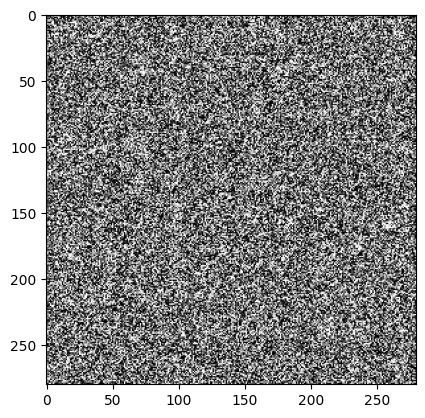

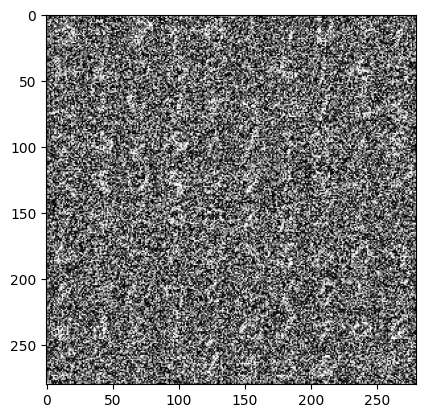

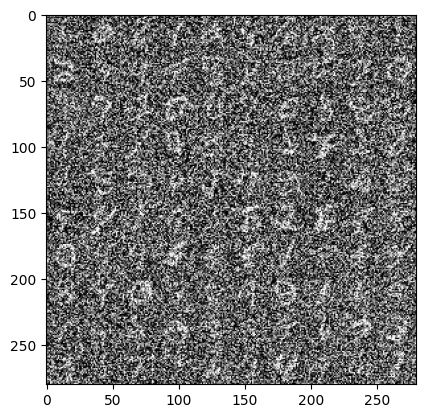

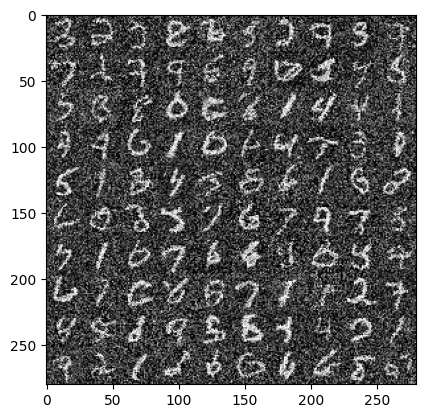

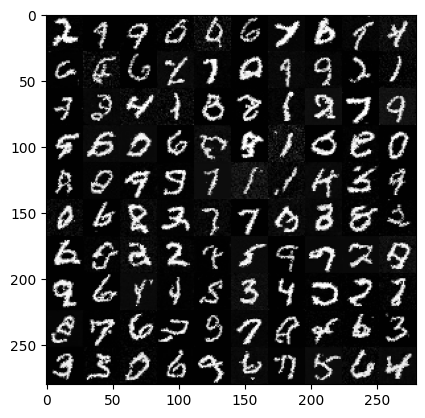

In [25]:
for i in np.arange(0.2,1.2,0.2):
  with torch.no_grad():
    traj = node.trajectory(
            torch.randn(100, 1, 28, 28).to(device),
            t_span=torch.linspace(0, i, 2).to(device),
        )
  grid = make_grid(
    traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
        )
  img = ToPILImage()(grid)
  plt.imshow(img)
  plt.show()

### Inference with saved weights

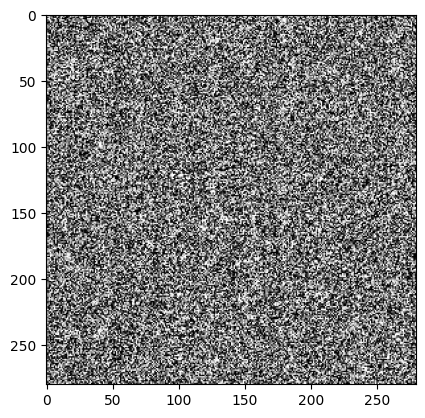

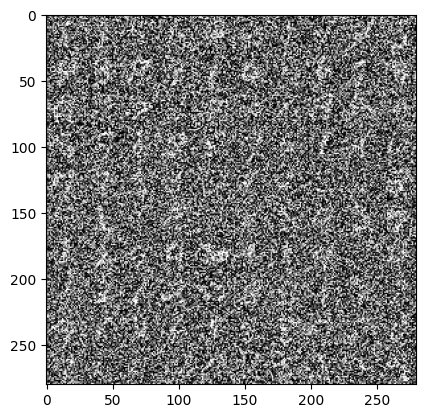

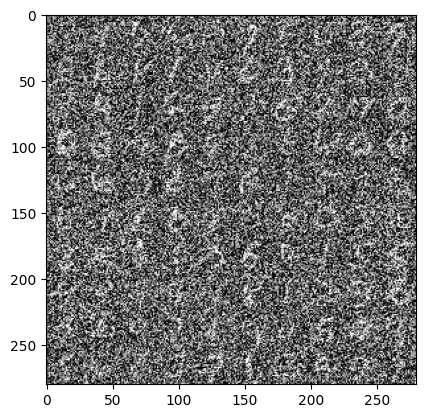

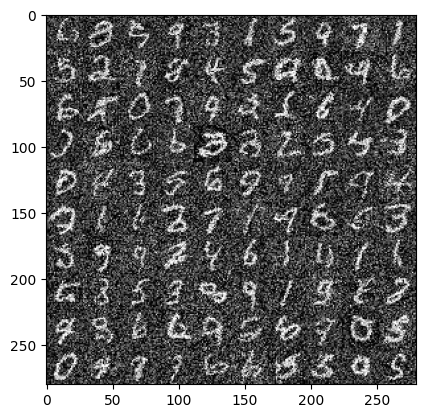

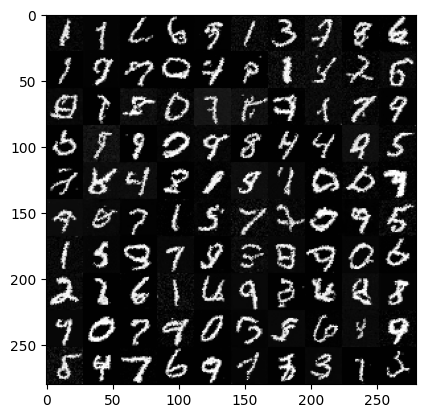

In [26]:
for i in np.arange(0.2,1.2,0.2):
  with torch.no_grad():
      traj2 = node2.trajectory(
          torch.randn(100, 1, 28, 28).to(device),
          t_span=torch.linspace(0, i, 2).to(device),
      )
  grid2 = make_grid(
      traj2[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
  )
  img2 = ToPILImage()(grid2)
  plt.imshow(img2)
  plt.show()